In [31]:
# Imports
import os
from pathlib import Path
import yaml
import zipfile

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset
from ultralytics import YOLO

In [2]:
# Settings
YOLO_V8N_VERSION = "8.3.0"
DATASET_PATH = Path("/workspace/dataset")
DATASET_ZIP_PATH = DATASET_PATH / "Human Face Expression.v20i.yolov8.zip"
DATASET_YAML_PATH = DATASET_PATH / "data.yaml"
MODELS_PATH = Path("/workspace/models")
PRETRAINED_MODEL_PATH = MODELS_PATH / "yolo_pretrained.pt"
EXPORT_STATE_PATH = MODELS_PATH / "yolo_state_dict.pth"

In [3]:
# Constants
NUM_COORDS_AND_OBJ_SCORE = 5    # 4 coordinates (x, y, w, h) + 1 object score

In [4]:
# Determine if we should execute on the CPU or GPU
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"   # Apple Silicon (Metal Performance Shaders)
else:
    device = "cpu"

print(f"Using device: {device}")

Using device: cuda


## Download dataset

**Manual step required**: Because Roboflow's API key expires every 24 hours, the easiest way to download the dataset is to manually grab it from Roboflow's site.

1. Sign in or create an account on [Roboflow](https://roboflow.com/).
2. Head to the [Human Face Expression Recognition dataset (v20)](https://universe.roboflow.com/human-face-expression-recognition/human-face-expression/dataset/20) on Roboflow.
3. Click **YOLOv8** under *Popular Download Formats**.
4. In the pop-up window, select **Download dataset** and click **Continue**.
5. In the next window, ensure that *YOLOv8* is selected under *Image and Annotation Format*. Select **Download zip to computer** and click **Continue**.
6. Copy the *.zip* file to the *workspace/dataset/* directory.
7. Run the following cells to unzip the dataset and check it.

In [16]:
# Unzip dataset
with zipfile.ZipFile(DATASET_ZIP_PATH, "r") as zip_ref:
    zip_ref.extractall(DATASET_PATH)

In [5]:
# Load the YAML
with open(DATASET_YAML_PATH, "r") as f:
    data_config = yaml.safe_load(f)

# Extract class names
class_names = data_config["names"]
num_classes = len(class_names)

# Display contents
print("data.yaml contents:")
for k, v in data_config.items():
    print(f"{k}: {v}")

data.yaml contents:
train: ../train/images
val: ../valid/images
test: ../test/images
nc: 7
names: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
roboflow: {'workspace': 'human-face-expression-recognition', 'project': 'human-face-expression', 'version': 20, 'license': 'CC BY 4.0', 'url': 'https://universe.roboflow.com/human-face-expression-recognition/human-face-expression/dataset/20'}


## Download model

In [4]:
# Download model weights (pre-trained on COCO)
!wget https://github.com/ultralytics/assets/releases/download/v{YOLO_V8N_VERSION}/yolov8n.pt -O {PRETRAINED_MODEL_PATH}

--2025-11-07 21:04:52--  https://github.com/ultralytics/assets/releases/download/v8.3.0/yolov8n.pt
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/521807533/101dd207-c6a9-4ee0-bfeb-34e12d2b8f40?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-11-07T21%3A48%3A30Z&rscd=attachment%3B+filename%3Dyolov8n.pt&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-11-07T20%3A47%3A38Z&ske=2025-11-07T21%3A48%3A30Z&sks=b&skv=2018-11-09&sig=fQO2r%2FqX1qD6%2FSVoaf7l8mrYl3HUUNRT4VHigbUDB1g%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc2MjU0OTc5MiwibmJmIjoxNzYyNTQ5NDkyLCJwYXRoIjoicmVsZWFzZWFzc2V0cHJvZHVjdGlvbi5ibG9iLmNvc

## Initialize model for transfer learning

We want to replace part of the detect head (final layers) with a new set of layers that output classification guesses (logits) for our new set of categories (face expressions) instead of the old COCO classes.

In [6]:
# Load the YOLOv8-nano model (pretrained on COCO dataset)
yolo = YOLO(PRETRAINED_MODEL_PATH)

# Access the underlying nn.Module
model = yolo.model

# Move model to CPU or GPU
model.to(device)

# Print model info
print("Number of parameters:", sum(p.numel() for p in model.parameters()))
print(model)

Number of parameters: 3157200
DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C2f(
      (cv1): Conv(
        (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): S

The detection head is composed of 3 parts:
* cv2 - outputs the box regression (x, y, w, h)
* cv3 - outputs the class logits: 80 categories for COCO
* dfl - converts discrete bins to continuous boxes (to refine box coordinates)

We want to replace cv3 with a similar set of new layers but output the new class logits (7 face expressions). We'll keep cv2 and dfl the same.

In [7]:
# Get the detection head from the model
detect = model.model[-1]

# Update YOLO head metadata
detect.nc = num_classes
detect.no = num_classes + NUM_COORDS_AND_OBJ_SCORE
detect.nl = len(detect.cv3)  # number of detection layers

# Replace the final 1x1 conv in each classification branch
for seq in detect.cv3:
    # Final part of each module is an 1x1 Conv2d layer for 80x80 input
    last_conv = seq[-1]  
    in_ch = last_conv.in_channels

    # Create new conv layer for 7 classes
    new_conv = torch.nn.Conv2d(in_ch, num_classes, kernel_size=1, stride=1)

    # Initialize weights (Kaiming/He normal initialization)
    torch.nn.init.kaiming_normal_(new_conv.weight, mode='fan_out', nonlinearity='relu')
    if new_conv.bias is not None:
        torch.nn.init.zeros_(new_conv.bias)

    # Replace the old layer
    seq[-1] = new_conv

# Show new cv3 part of detection head
print(detect.cv3)

ModuleList(
  (0): Sequential(
    (0): Conv(
      (conv): Conv2d(64, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): Conv2d(80, 7, kernel_size=(1, 1), stride=(1, 1))
  )
  (1): Sequential(
    (0): Conv(
      (conv): Conv2d(128, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.03, affine=True,

In [8]:
# Disable gradient updates (freeze) all parameters
for param in model.parameters():
    param.requires_grad = False

# Unfreeze cv3 part of the detection head
for name, param in model.named_parameters():
    if "cv3" in name:
        param.requires_grad = True

# Print out trainable layers
trainable = [name for name, p in model.named_parameters() if p.requires_grad]
print("Trainable layers:")
for name in trainable:
    print("  ", name)
print(f"Total trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Trainable layers:
   model.22.cv3.0.0.conv.weight
   model.22.cv3.0.0.bn.weight
   model.22.cv3.0.0.bn.bias
   model.22.cv3.0.1.conv.weight
   model.22.cv3.0.1.bn.weight
   model.22.cv3.0.1.bn.bias
   model.22.cv3.0.2.weight
   model.22.cv3.0.2.bias
   model.22.cv3.1.0.conv.weight
   model.22.cv3.1.0.bn.weight
   model.22.cv3.1.0.bn.bias
   model.22.cv3.1.1.conv.weight
   model.22.cv3.1.1.bn.weight
   model.22.cv3.1.1.bn.bias
   model.22.cv3.1.2.weight
   model.22.cv3.1.2.bias
   model.22.cv3.2.0.conv.weight
   model.22.cv3.2.0.bn.weight
   model.22.cv3.2.0.bn.bias
   model.22.cv3.2.1.conv.weight
   model.22.cv3.2.1.bn.weight
   model.22.cv3.2.1.bn.bias
   model.22.cv3.2.2.weight
   model.22.cv3.2.2.bias
Total trainable parameters: 498,021


In [9]:
# Get a list of trainable parameter tensors
trainable_params = [p for n, p in model.named_parameters() if p.requires_grad]

# Define a new optimizer
opt = torch.optim.AdamW(
    trainable_params,
    lr=1e-3,
    weight_decay=1e-4
)

# Print what we'll be training
print(f"Optimizer has {len(opt.param_groups[0]['params'])} parameter tensors.")
print(f"Total trainable params: {sum(p.numel() for p in trainable_params):,}")

Optimizer has 24 parameter tensors.
Total trainable params: 498,021


## Preprocessing

In [27]:
def preprocess_image(
    img_path,
    target_w=640,
    target_h=640,
    color=(0, 0, 0),
):
    """Load and preprocess an image for training"""
    # Load image
    img = cv2.imread(str(img_path), cv2.IMREAD_UNCHANGED)
    if img is None:
        raise FileNotFoundError(f"Image not found: {img_path}")

    # Convert image to RGB
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    elif img.shape[2] == 1:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    # Calculate new width and height in order to maintain aspect ratio
    h, w = img.shape[:2]
    scale = min(target_w / w, target_h / h)
    new_w, new_h = int(round(w * scale)), int(round(h * scale))

    # Resize with aspect ratio maintained
    img_resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    # Compute padding (center the image)
    pad_w, pad_h = target_w - new_w, target_h - new_h
    pad_left, pad_right = pad_w // 2, pad_w - pad_w // 2
    pad_top, pad_bottom = pad_h // 2, pad_h - pad_h // 2

    # Apply border padding (black background)
    img_padded = cv2.copyMakeBorder(
        img_resized,
        pad_top, pad_bottom, pad_left, pad_right,
        borderType=cv2.BORDER_CONSTANT,
        value=color,
    )

    return img_padded, scale, pad_left, pad_top

In [34]:
def adjust_bboxes_yolo(
    boxes, 
    orig_w, 
    orig_h, 
    target_w, 
    target_h, 
    scale, 
    pad_left, 
    pad_top,
):
    """Adjust YOLO-format bounding boxes after image preprocessing"""
    # Make sure we have boxes
    if len(boxes) == 0:
        return boxes

    # Convert boxes to float32
    boxes = np.array(boxes, dtype=np.float32)

    # Convert from normalized to original pixel coordinates
    cls = boxes[:, 0]
    xc = boxes[:, 1] * orig_w
    yc = boxes[:, 2] * orig_h
    bw = boxes[:, 3] * orig_w
    bh = boxes[:, 4] * orig_h

    # Apply scaling and padding
    xc = xc * scale + pad_left
    yc = yc * scale + pad_top
    bw *= scale
    bh *= scale

    # Convert back to normalized YOLO format (new image dimensions)
    xc /= target_w
    yc /= target_h
    bw /= target_w
    bh /= target_h

    # Re-stack into [cls, xc, yc, bw, bh]
    new_boxes = np.stack([cls, xc, yc, bw, bh], axis=1)
    
    return new_boxes.astype(np.float32)

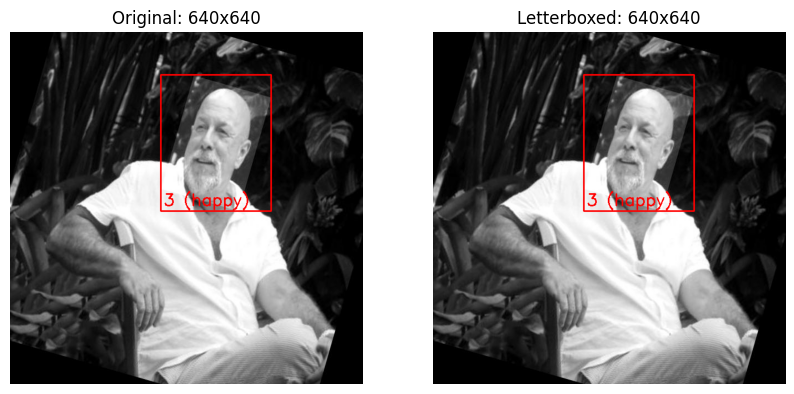

In [71]:
# Choose a single image and get bounding box info (label)
img_path = DATASET_PATH / "train/images/happy64_jpg.rf.c037db92937a4ca10c2c39b674fd3203.jpg"
label_path = DATASET_PATH / "train/labels" / (img_path.stem + ".txt")

# Load image to test our preprocessing pipeline
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img_h = img.shape[0]
img_w = img.shape[1]

# Modify with letterbox
target_w = 640
target_h = 640
img_lb, scale, pad_left, pad_top = letterbox(img, target_w, target_h)

# Load bounding boxes
boxes = []
with open(label_path) as f:
    for line in f:
        boxes.append(list(map(float, line.strip().split())))
boxes = np.array(boxes, dtype=np.float32)

# Adjust bounding box to work with preprocessed image
new_boxes = adjust_bboxes_yolo(
    boxes,
    img_w,
    img_h,
    target_w, 
    target_h,
    scale, 
    pad_left, 
    pad_top
)

# Convert original image to RGB for display
img_disp = cv2.cvtColor(img.copy(), cv2.COLOR_GRAY2BGR)

# Draw bounding boxes on original image
for cls, xc, yc, w, h in boxes:
    x1 = int((xc - w / 2) * img_w)
    y1 = int((yc - h / 2) * img_h)
    x2 = int((xc + w / 2) * img_w)
    y2 = int((yc + h / 2) * img_h)
    cv2.rectangle(img_disp, (x1, y1), (x2, y2), (255, 0, 0), 2)
    cv2.putText(
        img_disp, 
        f"{str(int(cls))} ({class_names[int(cls)]})", 
        (x1 + 5, y2 - 10),
        cv2.FONT_HERSHEY_SIMPLEX, 
        1.0, 
        (255, 0, 0), 
        2
    )

# Convert preprocessed image to RGB for display
img_lb_disp = cv2.cvtColor(img_lb.copy(), cv2.COLOR_GRAY2BGR)

# Draw bounding boxes on preprocessed image
for cls, xc, yc, w, h in new_boxes:
    x1 = int((xc - w / 2) * target_w)
    y1 = int((yc - h / 2) * target_h)
    x2 = int((xc + w / 2) * target_w)
    y2 = int((yc + h / 2) * target_h)
    cv2.rectangle(img_lb_disp, (x1, y1), (x2, y2), (255, 0, 0), 2)
    cv2.putText(
        img_lb_disp, 
        f"{str(int(cls))} ({class_names[int(cls)]})", 
        (x1 + 5, y2 - 10), 
        cv2.FONT_HERSHEY_SIMPLEX, 
        1.0, 
        (255, 0, 0), 
        2
    )

# Draw side-by-side images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Draw the original image
axes[0].imshow(img_disp)
axes[0].set_title(f"Original: {img.shape[1]}x{img.shape[0]}")
axes[0].axis('off')

# Draw the preprocessed image
axes[1].imshow(img_lb_disp)
axes[1].set_title(f"Letterboxed: {img_lb.shape[1]}x{img_lb.shape[0]}")
axes[1].axis('off')

# Show the images
plt.show()

In [26]:
class YoloDetectionDataset(Dataset):
    ###TODO: Update this with new preprocessing pipeline
    
    """
    YOLO-format dataset loader with grayscale replication and letterbox resizing.
    Each label file has one object per line: class xc yc w h (normalized).
    """
    def __init__(self, images_dir, labels_dir, img_size=640, transform=None):
        self.image_paths = sorted([
            os.path.join(images_dir, f)
            for f in os.listdir(images_dir)
            if f.endswith((".jpg", ".png"))
        ])
        self.labels_dir = labels_dir
        self.img_size = img_size
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label_path = os.path.join(
            self.labels_dir,
            os.path.splitext(os.path.basename(img_path))[0] + ".txt"
        )

        # --- Load image (grayscale → 3-channel RGB replication) ---
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise FileNotFoundError(f"Image not found: {img_path}")
        img = np.repeat(img[..., None], 3, axis=2)

        # --- Letterbox resize to maintain aspect ratio ---
        img, scale, pad_left, pad_top = letterbox(img, new_size=self.img_size)
        h, w = img.shape[:2]

        # --- Load labels (if available) ---
        boxes = []
        if os.path.exists(label_path):
            with open(label_path) as f:
                for line in f:
                    cls, xc, yc, bw, bh = map(float, line.strip().split())
                    # Convert normalized coords → pixel coords
                    xc, yc, bw, bh = xc * w, yc * h, bw * w, bh * h
                    boxes.append([cls, xc, yc, bw, bh])
        boxes = np.array(boxes, dtype=np.float32)

        # --- Convert to tensor ---
        img = torch.tensor(img).permute(2, 0, 1).float() / 255.0  # [3,640,640]
        labels = torch.tensor(boxes) if len(boxes) > 0 else torch.zeros((0, 5))

        # Apply optional transforms (augmentation, normalization, etc.)
        if self.transform:
            img = self.transform(img)

        return img, labels

In [27]:
# TODO: go through the above for understanding. Ask ChatGPT